# Contrasting experimental conditions
In this week's lecture we covered one method for contrasting brain activity in response to different kinds of trials. For this lab, we'll look at the ERP in response to another kind of event: auditory and visual. Each of these should have their own signature pattern of activity, as well as distributions across the brain. We'll then transition over to ECoG, where we can investigate how the patterns of specificity differ.

Finally, we'll also use resampling (bootstrap) statistics in order to both illustrate the variability present in our signals, as well as to make inferential statements about "how much" the brain activity differs between conditions.

# The Data
We'll use the same data from lecture in order to look at the activity in EEG. Our ECoG data will be the consonant / dissonant chords task we covered last week. This time, we'll start to incorporate more information about the trials into our analysis.

In [2]:
import mne
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
import neurods as nds
%matplotlib notebook

In [3]:
path_data_root = nds.io.data_list['eeg'] + 'mne_sample/'

* First, load 
 + the data ('mne_sample-raw.fif')
 + the events ('mne_sample-events.csv')
 + the event information ('mne_sample-event_info.csv') 
using the path_data_root path.

To load the data use MNE and make sure to preload the data.
To load the events file use datascience tables.

In [5]:
### STUDENT ANSWER
raw = mne.io.Raw(path_data_root + 'mne_sample-raw.fif')
ev_df = ds.Table.read_table(path_data_root + 'mne_sample-events.csv')
ev_info = ds.Table.read_table(path_data_root + 'mne_sample-event_info.csv')

Opening raw data file /home/shared/cogneuro-connector/data/eeg/mne_sample/mne_sample-raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated


* First, take a look again at what's inside the `ev_info` object. This tells us what kinds of trials we've got.
* Use it to create a dictionary that maps event names (strings) onto event ids (integers)

In [3]:
### STUDENT ANSWER
print(ev_info)

# We can also use our event info to create a dictionary MNE can use
ev_dict = dict()
for i_name, i_id, i_desc in ev_info.rows:
    ev_dict[i_name] = int(i_id)
print(ev_dict)

name   | id   | description
LA     | 1    | Response to left-ear auditory stimulus
RA     | 2    | Response to right-ear auditory stimulus
LV     | 3    | Response to left visual field stimulus
RV     | 4    | Response to right visual field stimulus
smiley | 5    | Response to the smiley face
button | 32   | Response triggered by the button press
{'LA': 1, 'RA': 2, 'LV': 3, 'button': 32, 'smiley': 5, 'RV': 4}


* Now, look at the `ev_df` object. This contains our actual event times, as well as which event type is associated with that time.
* Turn this events object into an MNE events array. Use the 'select' function. Remember, this is an array of shape `(n_events, 3)`. First column is the event index, second column is previous value, which is, `0`s, third column is the event type.

In [4]:
### STUDENT ANSWER
events = ev_df.select(['index', 'previous_value', 'event_type'])
events = np.vstack(events.columns).T

* Now, create the `Epochs` object associated with these events.
* Then, keep only the "Left Audio (LA)" and "Left Visual (LV)" event types. You can pass a list of event type strings to the `Epochs` object to do this.

In [5]:
### STUDENT ANSWER
epochs = mne.Epochs(raw, events, event_id=ev_dict)
epochs.event_id

320 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated


{'LA': 1, 'LV': 3, 'RA': 2, 'RV': 4, 'button': 32, 'smiley': 5}

In [6]:
### STUDENT ANSWER
epochs = epochs[['LA', 'LV']]

* Plot the average of each trial type using the MNE `Evoked` object.
* Mark the electrode name that has the highest deflection in each case. You should be able to click each line to display the channel name (make sure `%matplotlib notebook` has been run before this)

<IPython.core.display.Javascript object>


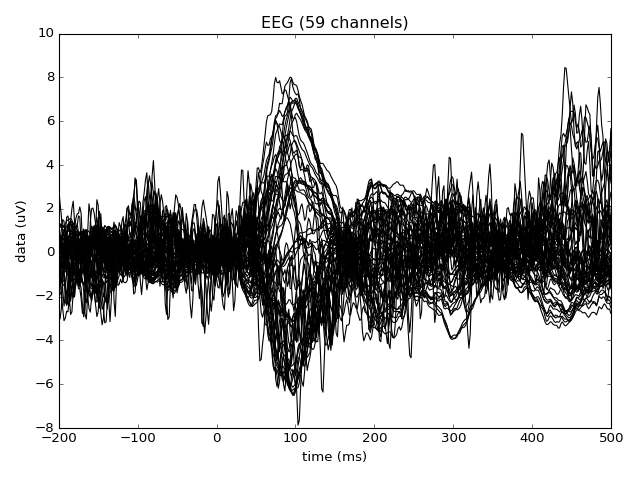

<IPython.core.display.Javascript object>


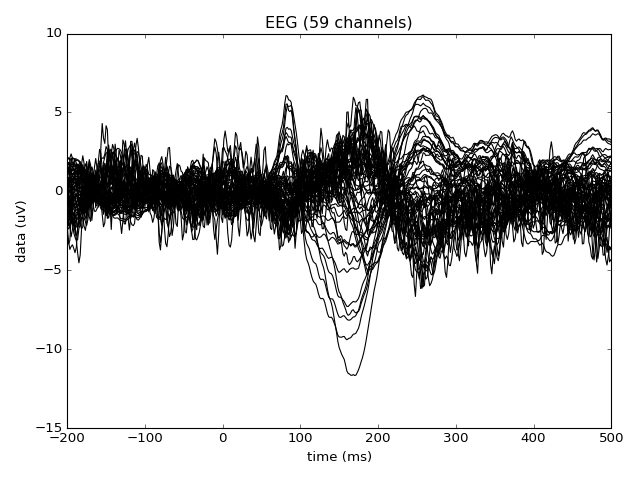

In [7]:
### STUDENT ANSWER
_ = epochs['LA'].average().plot()
_ = epochs['LV'].average().plot()

* Finally, make a `joint` plot for each condition that shows the topographies across the brain.

<IPython.core.display.Javascript object>


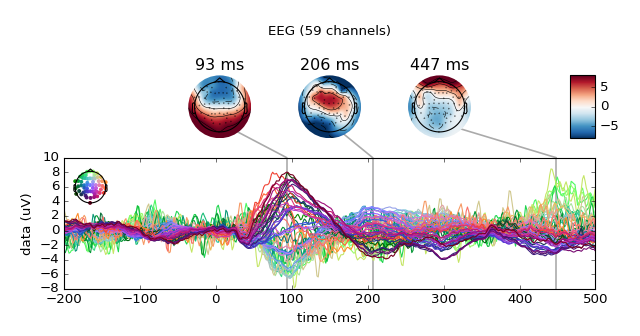

<IPython.core.display.Javascript object>


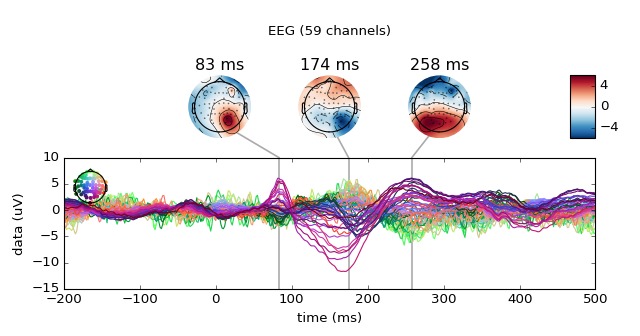

In [8]:
### STUDENT ANSWER
_ = epochs['LA'].average().plot_joint()
_ = epochs['LV'].average().plot_joint()

* Does there seem to be a clear pattern on the head for each one? What about a difference in how the activity progresses in time?

# Global Field Power
Assess the general pattern of activity across *all* electrodes. We'll calculate this below.

* First, calculate the mean across all trials for each stimulus type. Remember to square the result.
* Calculate the mean and standard error across all channels for each stimulus type.

In [9]:
### STUDENT ANSWER
# First calculate the mean across trials for each stimulus type
av_a = np.mean(epochs['LA'].get_data(), 0)
av_v = np.mean(epochs['LV'].get_data(), 0)

# Now, square the values
av_a_sq = av_a ** 2
av_v_sq = av_v ** 2

# Finally, calculate the mean and standard error across electrodes
glo_a = np.mean(av_a_sq, 0)
glo_v = np.mean(av_v_sq, 0)
ste_a = nds.stats.standard_error(av_a_sq)
ste_v = nds.stats.standard_error(av_v_sq)

Loading data for 72 events and 421 original time points ...
0 bad epochs dropped
Loading data for 73 events and 421 original time points ...
0 bad epochs dropped


* Plot the mean +/- standard error for each trial type. Make them two different colors

<IPython.core.display.Javascript object>


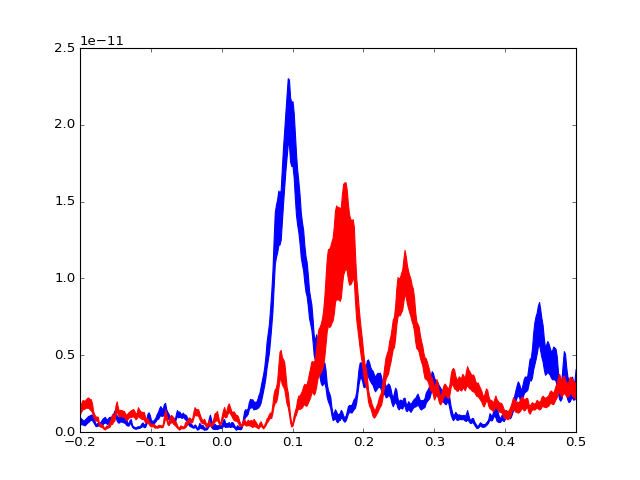

In [10]:
### STUDENT ANSWER
# Now plot the mean +/- standard error
f, ax = plt.subplots()
ax.fill_between(epochs.times, glo_a - ste_a, glo_a + ste_a, color='b')
ax.fill_between(epochs.times, glo_v - ste_v, glo_v + ste_v, color='r')

* Can you make any sense of these two patterns of activity?
* Do the plots tend to be larger or smaller in certain times over others?
* What can you say about the auditory vs. visual system from this data?

# ERPs in ECoG
Next we'll focus on the same trial averaging approaches that we've learned about in EEG. We'll see if the same kinds of signals come out of this approach, and examine the brain activity under a slightly more complex experiment.

This dataset was recorded during a task in which subjects listened to musical chords. These chords were either consonant, or dissonant. It was used to investigate whether auditory regions of the brain change their activity in response to these different types of sounds.

In [38]:
path_data_root = nds.io.data_list['ecog'] + 'chords_task/'

# Then load in the channel layout file as well as an image of the brain 
# You will use these two variables at the end of the lab for plotting in ECoG
lt = mne.channels.read_layout('brain', path_data_root)
im = plt.imread(path_data_root + 'brain.png')

* First, load 
 + the data ('ecog_resamp-raw.fif')
 + and event information ('meta_time.csv')

To load the data use MNE and make sure to preload the data.
To load the events file use datascience tables.

In [19]:
### STUDENT ANSWER
# You should preload the data, because it takes some time to load
raw = mne.io.Raw(path_data_root + 'ecog_resamp-raw.fif', preload=True)
events = ds.Table.read_table(path_data_root + 'meta_time.csv', index_col=0)

Opening raw data file /home/shared/cogneuro-connector/data/ecog/chords_task/ecog_resamp-raw.fif...
Isotrak not found
    Range : 0 ... 219521 =      0.000 ...   439.042 secs
Ready.
Reading 0 ... 219521  =      0.000 ...   439.042 secs...


* Plot the raw data. Remember to put the right "scanling".

In [ ]:
### STUDENT ANSWER
# Plot the raw channels and drop noisy channels
_ = raw.plot(scalings='auto')

* Look at our events object and see what kind of data we have
* Show the unique values in the `type` column to see what kinds of events exist

In [20]:
### STUDENT ANSWER
print(events)
print(np.unique(events['type']))

start   | type      | stop
4.96914 | consonant | 5.66914
10.0105 | consonant | 10.7105
28.3729 | consonant | 29.0729
47.8371 | consonant | 48.5371
58.3871 | consonant | 59.0871
65.2148 | consonant | 65.9148
75.5478 | consonant | 76.2478
81.1567 | consonant | 81.8567
84.729  | consonant | 85.429
86.5149 | consonant | 87.2149
... (95 rows omitted)
['consonant' 'dissonant' 'meow']


* How many event types do we have? Create a dictionary that maps the event names to event IDs for these events. For example, if the event types are "A", "B", "C", we want you to map it to 1, 2, 3 (or some other unique ID of your choice))
* Then, create a list of event IDs that maps onto the event onsets in this table. One ID for each event. 
(HINT: Use np.where function). Make sure you have the same amount of event IDs as you have envents.

In [30]:
### STUDENT ANSWER
print(events.size)

start | type | stop
105   | 105  | 105


In [21]:
### STUDENT ANSWER
# Create the ID types for each event, along with a dictionary for reference
event_dict = dict(consonant=1, dissonant=2)
event_ids = events['type']
event_ids = np.where(event_ids == 'consonant', 1, 2)

* Now convert the events object into an events array that can be later used in MNE. Remember that the first column should be the 'index' of when that event occurred, the second column is the 'previous value', with zeros; the third column is the 'event_type'. You will need to use the sampling frequency.

In [36]:
### STUDENT ANSWER
event_ixs = events['start'] * raw.info['sfreq']
event_ixs = np.vstack([event_ixs,
                       np.zeros_like(event_ixs),
                       event_ids])
event_ixs = event_ixs.astype(int).T
event_ixs[:10]

array([[ 2484,     0,     1],
       [ 5005,     0,     1],
       [14186,     0,     1],
       [23918,     0,     1],
       [29193,     0,     1],
       [32607,     0,     1],
       [37773,     0,     1],
       [40578,     0,     1],
       [42364,     0,     1],
       [43257,     0,     1]])

* Using the `Raw` object, along with this events array, create an `Epochs` object. Include times from -200ms to 500ms.
* Plot the average responses for each condition

The events passed to the Epochs constructor are not chronologically ordered.
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 351 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


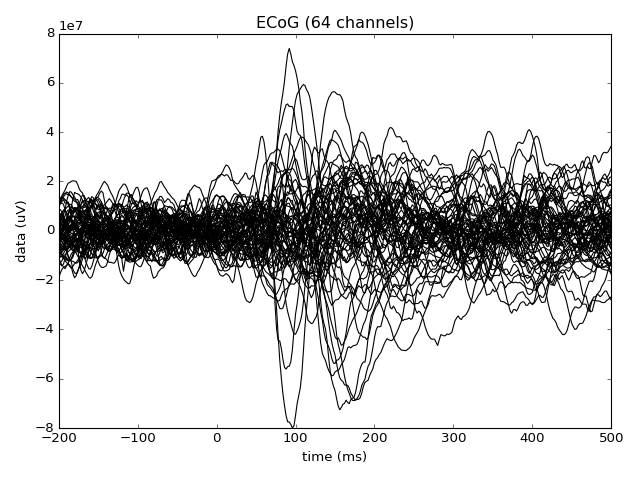

<IPython.core.display.Javascript object>


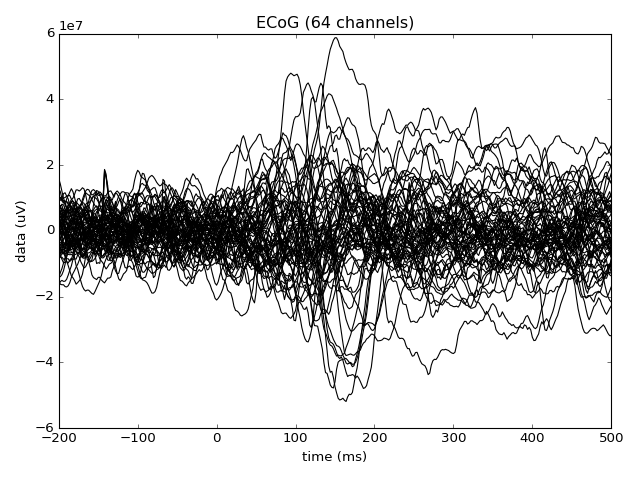

In [37]:
### STUDENT ANSWER
epochs = mne.Epochs(raw, event_ixs, event_dict,
                    tmin=-.2, tmax=.5, preload=True)


# Now calculate the average for each type of event separately
_ = epochs['consonant'].average().plot()
_ = epochs['dissonant'].average().plot()

Note that we can't make a "joint" plot for this, because each ECoG grid has a unique structure and location on the brain, so the "standard" scalp topographies won't work.

**However**, we can still plot averages using a custom topographic layout. This will give us a rough idea of where on the brain the activity exists.

* Use the `plot_topo` method of our `Evoked` object to plot the average waveform at each channel for each stimulus type/condition.
  * For a custom layout, use the `layout` parameter along with the layout file we loaded in the beginning of the ECoG section
  * To plot the image of the brain as well, use the `fig_background` parameter and pass the image file that we loaded in the beginning of the ECoG section

In [ ]:
### STUDENT ANSWER
# However, we can still plot averages with a custom topographic layout
# Use the `plot_topo` function after averaging
# For a custom layout, use the `layout` parameter along with
# `fig_background` to show the brain in the background.
_ = epochs['consonant'].average().plot_topo(layout=lt, fig_background=im)
_ = epochs['dissonant'].average().plot_topo(layout=lt, fig_background=im)